<a href="https://colab.research.google.com/github/superproger228/coursework/blob/main/PyTorch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import torch 
import pandas as pd 
import torch.nn as nn 
from torch.utils.data import random_split, DataLoader, TensorDataset 
import torch.nn.functional as F 
import numpy as np 
import torch.optim as optim 
from torch.optim import Adam
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
df = sns.load_dataset("iris")
df.rename(columns = {'species':'Iris_Type'}, inplace = True )
df.head() 
#df['Iris_Type'].value_counts()

,sepal_length,sepal_width,petal_length,petal_width,Iris_Type
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [65]:
labels = {'setosa':0, 'versicolor':1, 'virginica':2} 
df['IrisType_num'] = df['Iris_Type']  
df.IrisType_num = [labels[item] for item in df.IrisType_num]  
 
input = df.iloc[:,:-2]           
print(input, '\n')   
output = df.loc[:, 'IrisType_num']   
print(output)

     sepal_length  sepal_width  petal_length  petal_width
0             5.1          3.5           1.4          0.2
1             4.9          3.0           1.4          0.2
2             4.7          3.2           1.3          0.2
3             4.6          3.1           1.5          0.2
4             5.0          3.6           1.4          0.2
..            ...          ...           ...          ...
145           6.7          3.0           5.2          2.3
146           6.3          2.5           5.0          1.9
147           6.5          3.0           5.2          2.0
148           6.2          3.4           5.4          2.3
149           5.9          3.0           5.1          1.8

[150 rows x 4 columns] 

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: IrisType_num, Length: 150, dtype: int64


In [66]:
input = torch.Tensor(input.to_numpy())     
output = torch.tensor(output.to_numpy())        
data = TensorDataset(input, output)    

In [79]:
train_batch_size = 10        
number_rows = len(input) 
test_split = int(number_rows*0.1)  
validate_split = int(number_rows*0.2) 
train_split = number_rows - test_split - validate_split   #70% - train
train_set, validate_set, test_set = random_split( 
    data, [train_split, validate_split, test_split])    
 
train_loader = DataLoader(train_set, batch_size = train_batch_size, shuffle = True) 
validate_loader = DataLoader(validate_set, batch_size = 1) 
test_loader = DataLoader(test_set, batch_size = 1)

In [80]:
len(train_set)

105

In [83]:
input_size = list(input.shape)[1]   # = 4. 
learning_rate = 0.01 
output_size = len(labels)           
N = 10

class Network(nn.Module): 
   def __init__(self, input_size, output_size): 
       super(Network, self).__init__() 
        
       self.layer1 = nn.Linear(input_size, N) 
       self.layer2 = nn.Linear(N, N) 
       self.layer3 = nn.Linear(N, output_size) 

   def forward(self, x): 
       x1 = F.relu(self.layer1(x)) 
       x2 = F.relu(self.layer2(x1)) 
       x3 = self.layer3(x2) 
       return x3 
 
model = Network(input_size, output_size)

In [84]:
from torchsummary import summary
summary(model, (4,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              50
            Linear-2                   [-1, 10]             110
            Linear-3                    [-1, 3]              33
Total params: 193
Trainable params: 193
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [85]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

def saveModel(): 
    torch.save(model.state_dict(), 'checkpoint.pth') 

In [86]:
def train(num_epochs): 
    best_accuracy = 0.0 
    ep_train_loss = []
    ep_val_loss = []
    ep_accuracy = []
     
    for epoch in range(1, num_epochs+1): 
        running_train_loss = 0.0 
        running_accuracy = 0.0 
        running_vall_loss = 0.0 
        total = 0 

 
        for data in train_loader: 
            inputs, outputs = data   
            optimizer.zero_grad()   #зануление предыдущих значений градиента
            predicted_outputs = model(inputs)   
            train_loss = loss_fn(predicted_outputs, outputs)   
            train_loss.backward()   #градиенты
            optimizer.step()        #шаг оптимизатора
            running_train_loss +=train_loss.item()  
            

        train_loss_value = running_train_loss/len(train_loader) 
        ep_train_loss.append(train_loss_value)

        with torch.no_grad(): 
            model.eval() 
            for data in validate_loader: 
               inputs, outputs = data 
               predicted_outputs = model(inputs) 
               val_loss = loss_fn(predicted_outputs, outputs)         
               _, predicted = torch.max(predicted_outputs, 1) 
               running_vall_loss += val_loss.item()  
               total += outputs.size(0) 
               running_accuracy += (predicted == outputs).sum().item() 
 
        val_loss_value = running_vall_loss/len(validate_loader) 
        ep_val_loss.append(val_loss_value)  

        accuracy = (100 * running_accuracy / total)     
        ep_accuracy.append(accuracy)

        if accuracy > best_accuracy: 
            saveModel()
            best_accuracy = accuracy 
         
        print('batch', epoch, 'Training Loss: %.2f' %train_loss_value, 'Validation Loss: %.2f' %val_loss_value, 'Accuracy %d %%' % (accuracy))
    return ep_train_loss, ep_val_loss, ep_accuracy

In [87]:
def plot_train_process(ep_train_loss, ep_val_loss, ep_accuracy):
  fig, axes = plt.subplots(1, 2, figsize=(15,5))

  axes[0].set_title('Loss')
  axes[0].plot(ep_train_loss, label='train')
  axes[0].plot(ep_val_loss, label='validation')
  axes[0].legend()

  axes[1].set_title('Accuracy')
  axes[1].plot(ep_accuracy)

batch 1 Training Loss: 1.05 Validation Loss: 0.97 Accuracy 33 %
batch 2 Training Loss: 0.89 Validation Loss: 0.83 Accuracy 63 %
batch 3 Training Loss: 0.72 Validation Loss: 0.63 Accuracy 90 %
batch 4 Training Loss: 0.53 Validation Loss: 0.42 Accuracy 96 %
batch 5 Training Loss: 0.39 Validation Loss: 0.30 Accuracy 90 %
batch 6 Training Loss: 0.27 Validation Loss: 0.25 Accuracy 86 %
batch 7 Training Loss: 0.31 Validation Loss: 0.26 Accuracy 86 %
batch 8 Training Loss: 0.24 Validation Loss: 0.15 Accuracy 100 %
batch 9 Training Loss: 0.18 Validation Loss: 0.22 Accuracy 86 %
batch 10 Training Loss: 0.18 Validation Loss: 0.11 Accuracy 100 %
batch 11 Training Loss: 0.14 Validation Loss: 0.12 Accuracy 96 %
batch 12 Training Loss: 0.13 Validation Loss: 0.09 Accuracy 96 %
batch 13 Training Loss: 0.11 Validation Loss: 0.06 Accuracy 100 %
batch 14 Training Loss: 0.11 Validation Loss: 0.14 Accuracy 93 %
batch 15 Training Loss: 0.15 Validation Loss: 0.08 Accuracy 96 %
batch 16 Training Loss: 0.13 Va

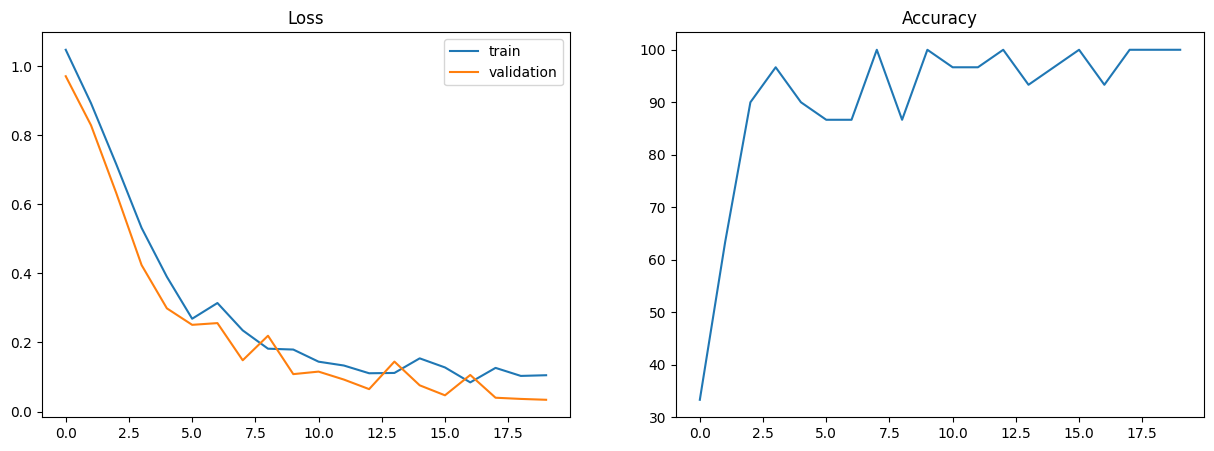

In [88]:
num_epochs = 20
ep_train_loss, ep_val_loss, ep_accuracy = train(num_epochs) 
plot_train_process(ep_train_loss, ep_val_loss, ep_accuracy)

In [89]:
def test(): 
     
    running_accuracy = 0 
    total = 0 
    model.load_state_dict(torch.load('checkpoint.pth')) 

    with torch.no_grad(): 
        for data in test_loader: 
            inputs, outputs = data 
            outputs = outputs.to(torch.float32) 
            predicted_outputs = model(inputs) 
            _, predicted = torch.max(predicted_outputs, 1) 
            total += outputs.size(0) 
            running_accuracy += (predicted == outputs).sum().item() 
 
        print('Accuracy: %d %%' % (100 * running_accuracy / total))    
 

In [92]:
test() 

Accuracy: 100 %


In [76]:
#list(model.parameters())  

In [77]:
#model.state_dict() 

In [78]:
#model.state_dict().keys()